In [4]:
import numpy as np
import matplotlib.pyplot as plt

In [5]:
data = np.array([7., 10., 11., 10., 8., 14., 12., 9., 12., 13.,
        10., 11., 12., 11., 13., 9., 10., 12., 11.,
        7., 7., 12., 10., 6., 8., 11., 9., 9., 9., 9.])

In [6]:
errors = np.array([3.18, 3.45, 2.92, 3.14, 3.43, 2.85, 3.18,
         3.14, 3.12, 3.03, 3.12, 3.07, 3.08, 3.41,
         3.32, 3.44, 3.31, 3.21, 2.87, 3.07, 2.89,
         3.06, 2.93, 2.90, 3.32, 2.99, 3.08, 3.18,
         3.40, 3.01])

In [7]:
def gaussian_log_likelihood(data, errors, params):
    g_mean = params[0]
    return np.longdouble(-0.5*np.sum(np.power((data-g_mean)/errors, 2)))

In [8]:
means = np.linspace(0, 20, 100)
likelihoods = np.exp([gaussian_log_likelihood(data, errors, [p]) for p in means])

In [9]:
gaussian_log_likelihood(data, errors, [5.])

-46.054485234637027702

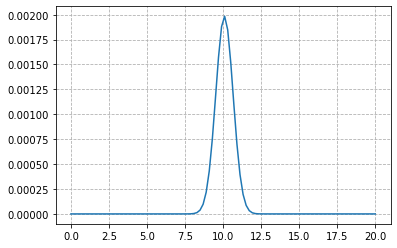

In [10]:
plt.plot(means, likelihoods)
plt.grid(linestyle='--')

### Analytic parameter

In [11]:
errors2 = np.power(errors, 2)
uhat = np.sum(data/errors2)/np.sum(1/errors2)
uhat

10.086872187189902

## Brute-force grids

Actually this is done when plotting. The numpy linspace is the grid and the likelihoods are evaluations at each parameter.

In [12]:
def normal_stddev(means, likelihoods):
    m = means.dot(likelihoods)
    mom2 = np.power(means, 2).dot(likelihoods)
    variance = mom2 - np.power(m, 2)
    return np.sqrt(variance)

In [13]:
normal_stddev(means, likelihoods)/2

0.5942454406497251285

## Varying $\chi^2$

In [14]:
def chisq(data, errors, params):
    g_mean = params[0]
    return np.sum(np.power((data-g_mean)/errors, 2))

In [15]:
chisq_values = [chisq(data, errors, [p]) for p in means]

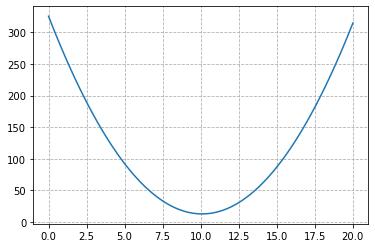

In [16]:
plt.plot(means, chisq_values)
plt.grid(linestyle='--')

In [17]:
min_chisq = np.min(chisq_values)
min_chisq

12.445169112634476

In [18]:
from scipy.optimize import fsolve, fmin

In [19]:
minhat = fmin(lambda x: chisq(data, errors, [x]), [10.])[0]
minhat

Optimization terminated successfully.
         Current function value: 12.444554
         Iterations: 14
         Function evaluations: 28


10.08685302734375

In [20]:
min_1_hat = fmin(lambda x: np.abs(
    chisq(data, errors, [x])-(min_chisq+1)),
                 [minhat])[0]
min_1_hat

Optimization terminated successfully.
         Current function value: 0.000093
         Iterations: 14
         Function evaluations: 28


10.656947381794453

In [21]:
min_chisq+1

13.445169112634476

In [22]:
np.abs(min_1_hat-minhat)

0.5700943544507027

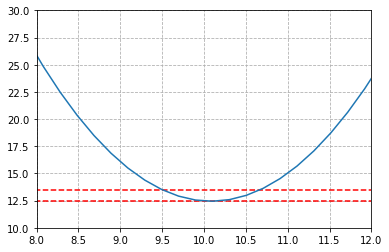

In [23]:
plt.plot(means, chisq_values)
plt.grid(linestyle='--')
plt.ylim(10, 30)
plt.xlim(8, 12)
plt.hlines(np.min(chisq_values), 0, 20, color='red', linestyles='--')
plt.hlines(np.min(chisq_values)+1, 0, 20, color='red', linestyles='--')

## Fisher matrix

$\frac{d^2 log\mathcal{L}(D;\mu)}{d\mu^2}=\sum_{n=1}^N\frac{1}{\sigma_n^2}$

$\hat{\sigma}_\mu^2=\Bigg(\sum_{n=1}^N\frac{1}{\sigma_n^2}\Bigg)^{-1}$

In [24]:
def fisher_matrix_for_gaussian(errors):
    return np.sum(1/np.power(errors, 2))

In [25]:
np.sqrt(1/fisher_matrix_for_gaussian(errors))

0.5699262170527927

## MCMC

In [27]:
def metropolis_hastings(steps, stddev, start_guess):
    points = []
    
    current_point = start_guess
    current_likelihood = gaussian_log_likelihood(data, errors, [current_point])
    
    for i in range(steps):
        points.append(current_point)
        
        proposed_point = np.random.normal(loc=current_point, scale=stddev)
        proposed_likelihood = gaussian_log_likelihood(data, errors, [proposed_point])
        
        if proposed_likelihood>current_likelihood:
            current_point = proposed_point
            current_likelihood = proposed_likelihood
        else:
            u = np.random.uniform(0.0, 1.0)
            if (u < np.exp(proposed_likelihood-current_likelihood)):
                current_point = proposed_point
                current_likelihood = proposed_likelihood
        
        points.append(current_point)
    
    return points

In [34]:
p = metropolis_hastings(10000, 1., 10.)

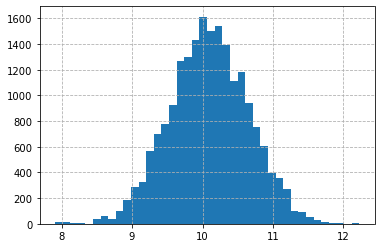

In [39]:
counts, steps, _ = plt.hist(p, bins=40);
plt.grid(linestyle='--')

In [41]:
np.mean(p)

10.090362884659127

In [40]:
normal_stddev(steps[:-1], counts/np.sum(counts))

0.5601029247786627